In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim import lr_scheduler
from tempfile import TemporaryDirectory

In [2]:
if torch.cuda.is_available():
    # Set the device to CUDA (GPU 0)
    device = torch.device("cuda:0")
else:
    # If no GPU is available, fall back to CPU
    device = torch.device("cpu")

In [3]:
os.getcwd()

'/home/intern/Documents/King_Hang/School'

In [4]:
base_path = "/home/intern/Documents/King_Hang/School/"
# os.chdir(BASE_PATH)

# path to animal classes
ANIMALS_PATH = './animals'

# Use only images in training folder
STYLE_ANIMALS_PATH = './style_animals/train/' 

In [5]:
from torchvision import transforms

data_dir = os.getcwd()
BATCH_SIZE = 4
IMAGE_SIZE = (224, 224)

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define a custom dataset
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 2])

        if self.transform:
            image = self.transform(image)

        return image, label

### Create dataloaders

1. Animals
2. Stylized Animals

#### 1. Animals

##### Visualize

##### Data Augmentation, create datasets, create dataloaders

In [6]:
def create_dataloaders(path: str):
    data = {"imgpath": [] , "labels": [] }

    category = os.listdir(path)
    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)

    df = pd.DataFrame(data) 

    #Convert labels to numbers
    lb = LabelEncoder()
    df['encoded_labels'] = lb.fit_transform(df['labels'])

    # Split data into train-valid-test
    train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
    valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
    train_df = train_df.reset_index(drop=True)
    valid_df = valid_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    print("----------Train-------------")
    print(train_df[["imgpath", "labels"]].head(5))
    print(train_df.shape)
    print("--------Validation----------")
    print(valid_df[["imgpath", "labels"]].head(5))
    print(valid_df.shape)
    print("----------Test--------------")
    print(test_df[["imgpath", "labels"]].head(5))
    print(test_df.shape)

    plt.figure(figsize=(8,5))
    for i, row in test_df.sample(n=4).reset_index().iterrows():
        plt.subplot(2,2,i+1)
        image_path = row['imgpath']
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title(row["labels"])
        plt.axis('off')
    plt.show()

    data_dir = os.getcwd()
    BATCH_SIZE = 4
    IMAGE_SIZE = (224, 224)


    # create datasets
    trainset = ImageDataset(dataframe=train_df, root_dir=data_dir, transform=transform)
    validset = ImageDataset(dataframe=valid_df, root_dir=data_dir, transform=transform)
    testset = ImageDataset(dataframe=test_df, root_dir=data_dir, transform=transform)

    # create dataloaders
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)
    validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=2)

    dataset_sizes = {'train': len(train_df), 'val': len(valid_df), 'test': len(test_df)}

    return trainloader, validloader, testloader, dataset_sizes

----------Train-------------
                                imgpath       labels
0         ./animals/goat/4f21ad4aa0.jpg         goat
1   ./animals/woodpecker/3a7fd9e840.jpg   woodpecker
2         ./animals/moth/9e81bc5555.jpg         moth
3        ./animals/shark/40f50c6990.jpg        shark
4  ./animals/hummingbird/8db010d774.jpg  hummingbird
(3779, 3)
--------Validation----------
                             imgpath    labels
0     ./animals/koala/9ca7babf11.jpg     koala
1      ./animals/goat/2e7b3347db.jpg      goat
2       ./animals/pig/1d8c1f3bbd.jpg       pig
3  ./animals/seahorse/37aaf8c8d7.jpg  seahorse
4  ./animals/mosquito/7cc15cecf2.jpg  mosquito
(1134, 3)
----------Test--------------
                             imgpath    labels
0     ./animals/otter/7c3868b76f.jpg     otter
1    ./animals/turtle/05e2720400.jpg    turtle
2     ./animals/whale/3b4307af02.jpg     whale
3      ./animals/lion/7d8f058238.jpg      lion
4  ./animals/seahorse/2cd0c57bad.jpg  seahorse
(487, 3)


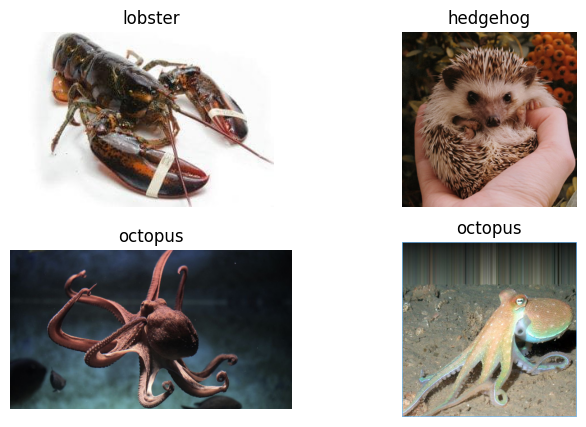

In [ ]:
trainloader, validloader, testloader, dataset_sizes = create_dataloaders(ANIMALS_PATH)
dataloaders = {'train': trainloader, 'val': validloader, 'test': testloader}

##### Stylized Animals

----------Train-------------
                                            imgpath       labels
0         ./style_animals/train/goat/4f21ad4aa0.jpg         goat
1   ./style_animals/train/woodpecker/3a7fd9e840.jpg   woodpecker
2         ./style_animals/train/moth/9e81bc5555.jpg         moth
3        ./style_animals/train/shark/40f50c6990.jpg        shark
4  ./style_animals/train/hummingbird/8db010d774.jpg  hummingbird
(3779, 3)
--------Validation----------
                                         imgpath    labels
0     ./style_animals/train/koala/9ca7babf11.jpg     koala
1      ./style_animals/train/goat/2e7b3347db.jpg      goat
2       ./style_animals/train/pig/1d8c1f3bbd.jpg       pig
3  ./style_animals/train/seahorse/37aaf8c8d7.jpg  seahorse
4  ./style_animals/train/mosquito/7cc15cecf2.jpg  mosquito
(1134, 3)
----------Test--------------
                                         imgpath    labels
0     ./style_animals/train/otter/7c3868b76f.jpg     otter
1    ./style_animals/train/turt

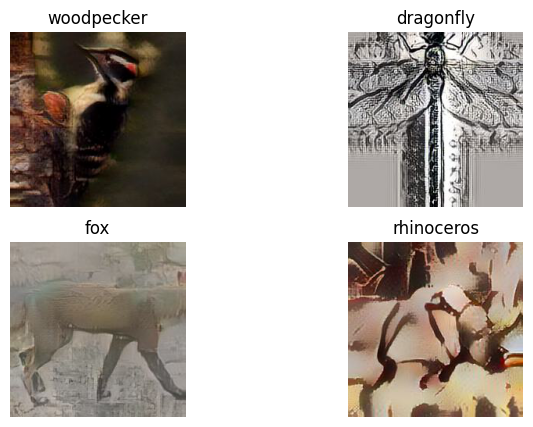

In [ ]:
s_trainloader, s_validloader, s_testloader, s_dataset_sizes = create_dataloaders(STYLE_ANIMALS_PATH)
s_dataloaders = {'train': s_trainloader, 'val': s_validloader, 'test':s_testloader}

#### Top 5 Accuracy

Top-5 accuracy provides a more forgiving evaluation metric by considering whether the correct class is within the top 5 predicted classes. This is especially relevant in image recognition, where there can be a vast number of object categories. 

High top-5 accuracy indicates that the model is not only good at picking the most likely class but also capable of recognizing other plausible classes. 

It's especially useful when comparing models that have similar performance on the top-1 (single most likely class) accuracy but differ in their ability to provide a ranked list of possible classes.

##### Training code

In [ ]:
import time
# From Official Pytorch page: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
            
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### What to do now?

Completed:
1. Pretrained + no finetuning
2. Pretrained + finetuning

Next:
1. Pretrained + finetuned + train stylized
2. Pretrained + train stylized
2. 
2. Write report if performance improves directly
3. If performance is terrible, then corrupt images, then test performance for shape-biased animals
5. If neither works, then try the animals 10 dataset
6. Also try image to sketch, then train on those

---

#### 1. Pretrained + finetune + train on stylized

##### Load model state dict

In [28]:
# Create instance of ResNet18 with modified output
res18 = models.resnet18()
num_ftrs = res18.fc.in_features
res18.fc = nn.Linear(num_ftrs, 90)

# Load the saved model state dictionary
checkpoint = torch.load("resnet18_weights.pth")

# Load the model weights from the state dictionary
res18.load_state_dict(checkpoint)

<All keys matched successfully>

In [34]:
res18 = res18.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(res18.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

res18 = train_model(res18, criterion, optimizer_ft, exp_lr_scheduler, dataloaders = s_dataloaders,
                       num_epochs=25)

Epoch 0/24
----------


train Loss: 3.0380 Acc: 0.2789
val Loss: 2.5214 Acc: 0.4162

Epoch 1/24
----------
train Loss: 1.6180 Acc: 0.5800
val Loss: 2.3589 Acc: 0.4612

Epoch 2/24
----------
train Loss: 0.7682 Acc: 0.8214
val Loss: 2.0631 Acc: 0.5106

Epoch 3/24
----------
train Loss: 0.3499 Acc: 0.9317
val Loss: 2.0162 Acc: 0.5291

Epoch 4/24
----------
train Loss: 0.1653 Acc: 0.9751
val Loss: 1.8469 Acc: 0.5644

Epoch 5/24
----------
train Loss: 0.1150 Acc: 0.9809
val Loss: 1.8758 Acc: 0.5697

Epoch 6/24
----------
train Loss: 0.0789 Acc: 0.9894
val Loss: 1.8690 Acc: 0.5697

Epoch 7/24
----------
train Loss: 0.0614 Acc: 0.9923
val Loss: 1.7900 Acc: 0.5838

Epoch 8/24
----------
train Loss: 0.0481 Acc: 0.9952
val Loss: 1.7576 Acc: 0.6005

Epoch 9/24
----------
train Loss: 0.0484 Acc: 0.9934
val Loss: 1.7370 Acc: 0.5952

Epoch 10/24
----------
train Loss: 0.0449 Acc: 0.9952
val Loss: 1.7066 Acc: 0.6049

Epoch 11/24
----------
train Loss: 0.0480 Acc: 0.9950
val Loss: 1.7103 Acc: 0.6041

Epoch 12/24
----------
t

Now for ResNet50:


Hypothesis - it does not learn as well since larger models do not propagate gradients as easily.

In [37]:
# Create instance of ResNet18 with modified output
res50 = models.resnet50()
num_ftrs = res50.fc.in_features
res50.fc = nn.Linear(num_ftrs, 90)

# Load the saved model state dictionary
checkpoint = torch.load("resnet50_weights.pth")

# Load the model weights from the state dictionary
res50.load_state_dict(checkpoint)

<All keys matched successfully>

In [38]:
res50 = res50.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(res50.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

res50 = train_model(res50, criterion, optimizer_ft, exp_lr_scheduler, dataloaders = s_dataloaders,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 3.2841 Acc: 0.2456
val Loss: 3.0746 Acc: 0.3395

Epoch 1/24
----------
train Loss: 2.0726 Acc: 0.4776
val Loss: 3.2833 Acc: 0.3898

Epoch 2/24
----------
train Loss: 1.3399 Acc: 0.6499
val Loss: 2.5618 Acc: 0.4577

Epoch 3/24
----------
train Loss: 0.7534 Acc: 0.8026
val Loss: 2.6033 Acc: 0.5159

Epoch 4/24
----------
train Loss: 0.4181 Acc: 0.9047
val Loss: 2.3830 Acc: 0.5282

Epoch 5/24
----------
train Loss: 0.2258 Acc: 0.9495
val Loss: 2.2586 Acc: 0.5573

Epoch 6/24
----------
train Loss: 0.1724 Acc: 0.9630
val Loss: 2.2144 Acc: 0.5503

Epoch 7/24
----------
train Loss: 0.0832 Acc: 0.9849
val Loss: 2.0312 Acc: 0.5794

Epoch 8/24
----------
train Loss: 0.0742 Acc: 0.9878
val Loss: 2.0230 Acc: 0.5864

Epoch 9/24
----------
train Loss: 0.0586 Acc: 0.9910
val Loss: 1.9607 Acc: 0.5944

Epoch 10/24
----------
train Loss: 0.0497 Acc: 0.9902
val Loss: 1.9293 Acc: 0.5882

Epoch 11/24
----------
train Loss: 0.0506 Acc: 0.9923
val Loss: 1.9050 Acc: 0.5961

Ep

#### 2. Pretrained + train stylized

Hypothesis: performs worse because it sees fewer animal pictures

In [35]:
# Create instance of ResNet18 with modified output
res18 = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = res18.fc.in_features
res18.fc = nn.Linear(num_ftrs, 90)

In [36]:
res18 = res18.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(res18.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

res18 = train_model(res18, criterion, optimizer_ft, exp_lr_scheduler, dataloaders = s_dataloaders,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 4.1790 Acc: 0.0709
val Loss: 3.2812 Acc: 0.1966

Epoch 1/24
----------
train Loss: 2.8828 Acc: 0.2958
val Loss: 2.4436 Acc: 0.3836

Epoch 2/24
----------
train Loss: 1.9456 Acc: 0.5239
val Loss: 2.3988 Acc: 0.4312

Epoch 3/24
----------
train Loss: 1.2042 Acc: 0.7145
val Loss: 2.3043 Acc: 0.4577

Epoch 4/24
----------
train Loss: 0.6213 Acc: 0.8748
val Loss: 2.0509 Acc: 0.5053

Epoch 5/24
----------
train Loss: 0.3164 Acc: 0.9500
val Loss: 2.0235 Acc: 0.5229

Epoch 6/24
----------
train Loss: 0.1895 Acc: 0.9762
val Loss: 1.9909 Acc: 0.5450

Epoch 7/24
----------
train Loss: 0.1149 Acc: 0.9865
val Loss: 1.8311 Acc: 0.5829

Epoch 8/24
----------
train Loss: 0.0921 Acc: 0.9926
val Loss: 1.7952 Acc: 0.5855

Epoch 9/24
----------
train Loss: 0.0768 Acc: 0.9934
val Loss: 1.8257 Acc: 0.5750

Epoch 10/24
----------
train Loss: 0.0593 Acc: 0.9976
val Loss: 1.7765 Acc: 0.5908

Epoch 11/24
----------
train Loss: 0.0653 Acc: 0.9939
val Loss: 1.7903 Acc: 0.5952

Ep

#### 3. Pretrained ON the entire Stylized ImageNet

Their repository offers pretrained models   
https://github.com/rgeirhos/texture-vs-shape

In [16]:
import sys

T_PATH = '/home/intern/Documents/King_Hang/School/texture-vs-shape/models/'

sys.path.append(T_PATH)

In [17]:
from load_pretrained_models import load_model

model_A = "resnet50_trained_on_SIN"
model_B = "resnet50_trained_on_SIN_and_IN"
model_C = "resnet50_trained_on_SIN_and_IN_then_finetuned_on_IN"

##### Model A

Train and fine-tune on animals dataset

In [12]:
model = load_model(model_name = model_A)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders = s_dataloaders,
                       num_epochs=25)

NameError: name 'load_model' is not defined

##### Model B

In [24]:
model = load_model(model_name = model_B) # or model_B or model_C

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders = s_dataloaders,
                       num_epochs=25)

Using the ResNet50 architecture.


Downloading: "https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/60b770e128fffcbd8562a3ab3546c1a735432d03/resnet50_train_45_epochs_combined_IN_SF-2a0d100e.pth.tar" to /home/intern/.cache/torch/hub/checkpoints/resnet50_train_45_epochs_combined_IN_SF-2a0d100e.pth.tar
100%|██████████| 195M/195M [00:09<00:00, 21.6MB/s] 


Epoch 0/24
----------
train Loss: 4.3515 Acc: 0.1133
val Loss: 2.7790 Acc: 0.3430

Epoch 1/24
----------
train Loss: 2.4601 Acc: 0.3935
val Loss: 2.3919 Acc: 0.4400

Epoch 2/24
----------
train Loss: 1.5009 Acc: 0.6200
val Loss: 2.1987 Acc: 0.4982

Epoch 3/24
----------
train Loss: 0.8461 Acc: 0.7968
val Loss: 1.9702 Acc: 0.5688

Epoch 4/24
----------
train Loss: 0.4378 Acc: 0.9034
val Loss: 1.7682 Acc: 0.6173

Epoch 5/24
----------
train Loss: 0.2457 Acc: 0.9513
val Loss: 1.6504 Acc: 0.6402

Epoch 6/24
----------
train Loss: 0.1644 Acc: 0.9733
val Loss: 1.6652 Acc: 0.6464

Epoch 7/24
----------
train Loss: 0.1140 Acc: 0.9794
val Loss: 1.5852 Acc: 0.6561

Epoch 8/24
----------
train Loss: 0.0769 Acc: 0.9886
val Loss: 1.5420 Acc: 0.6578

Epoch 9/24
----------
train Loss: 0.0746 Acc: 0.9905
val Loss: 1.5269 Acc: 0.6649

Epoch 10/24
----------
train Loss: 0.0614 Acc: 0.9910
val Loss: 1.5363 Acc: 0.6702

Epoch 11/24
----------
train Loss: 0.0676 Acc: 0.9899
val Loss: 1.5057 Acc: 0.6728

Ep

##### Model C:

In [18]:
modelC = load_model(model_name = model_B) # or model_B or model_C

modelC = modelC.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(modelC.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

modelC = train_model(modelC, criterion, optimizer_ft, exp_lr_scheduler, dataloaders = s_dataloaders,
                       num_epochs=25)

Using the ResNet50 architecture.


/home/intern/anaconda3/envs/kh_base/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intern/anaconda3/envs/kh_base/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 4.2029 Acc: 0.1400
val Loss: 2.8785 Acc: 0.3510

Epoch 1/24
----------
train Loss: 2.3437 Acc: 0.4088
val Loss: 2.4542 Acc: 0.4418

Epoch 2/24
----------
train Loss: 1.4847 Acc: 0.6234
val Loss: 2.3077 Acc: 0.5159

Epoch 3/24
----------
train Loss: 0.8141 Acc: 0.8060
val Loss: 1.7645 Acc: 0.5811

Epoch 4/24
----------
train Loss: 0.4483 Acc: 0.9008
val Loss: 1.6772 Acc: 0.6429

Epoch 5/24
----------
train Loss: 0.2293 Acc: 0.9547
val Loss: 1.6824 Acc: 0.6420

Epoch 6/24
----------
train Loss: 0.1606 Acc: 0.9712
val Loss: 1.6813 Acc: 0.6455

Epoch 7/24
----------
train Loss: 0.1204 Acc: 0.9809
val Loss: 1.4951 Acc: 0.6790

Epoch 8/24
----------
train Loss: 0.0753 Acc: 0.9894
val Loss: 1.4690 Acc: 0.6764

Epoch 9/24
----------
train Loss: 0.0738 Acc: 0.9892
val Loss: 1.4407 Acc: 0.6772

Epoch 10/24
----------
train Loss: 0.0650 Acc: 0.9910
val Loss: 1.4187 Acc: 0.6852

Epoch 11/24
----------
train Loss: 0.0541 Acc: 0.9923
val Loss: 1.4039 Acc: 0.6817

Ep

In [19]:
# test on test-set
def get_accuracy(model, testloader):

    model.eval()
    model = model.to(device)
    correct = 0
    total = 0
    predictions = list()

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Record predictions
            predictions.append(outputs)

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    return predictions

In [20]:
predictions = get_accuracy(modelC, testloader)

Test Accuracy: 66.53%


In [21]:
# batch-size = 4
predictions[0]

tensor([[ 5.6554,  4.9917,  7.0036,  ..., -2.7624, -2.3297, -1.9263],
        [ 5.9751,  7.7589,  6.5799,  ..., -0.1132,  1.5775, -1.3931],
        [ 3.3728,  5.0301,  1.3591,  ..., -1.0053,  1.3697, -0.1251],
        [ 8.2862,  0.2347,  5.5369,  ..., -1.2942,  0.0532, -1.8119]],
       device='cuda:0')

In [ ]:
def top5_accuracy(predictions, targets):
    """
    Calculate the top-5 accuracy.

    Args:
    predictions: A 2D NumPy array of shape (num_samples, num_classes) containing predicted probabilities or scores.
    targets: A 1D NumPy array of shape (num_samples) containing the true class labels.

    Returns:
    The top-5 accuracy as a percentage (0-100).
    """
    top5_preds = np.argsort(predictions, axis=1)[:, -5:]  # Get the indices of the top 5 predictions
    correct = np.sum(top5_preds == targets.reshape(-1, 1))  # Compare with true labels
    accuracy = (correct / len(targets)) * 100  # Calculate accuracy as a percentage
    return accuracy

In [ ]:
def top_5_accuracy(predictions, labels):
    _, top5_predictions = torch.topk(predictions, 5, dim=1)
    correct = top5_predictions.eq(labels.view(-1, 1).expand_as(top5_predictions))
    top5_acc = correct.sum().item() / len(labels)
    return top5_acc

modelC.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in testloader:
        # Assuming 'model' is your trained model
        outputs = modelC(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

NameError: name 'model' is not defined

#### 3. Write report if performance improves directly

#### 4. Corrupt images